In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mK as mK
from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2 as mf2
from TO_sim.Get_groups import phase_diagram,make_meanr

from TO_sim.To_Draw import Draw_avg_vel_r
from TO_sim.gen_Distribution import Normal
from TO_sim.gen_Distribution import Quantile_Normal as Q_Normal
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from tqdm.notebook import tqdm
from scipy.signal import find_peaks
import parmap
from pprint import pprint

In [2]:
def cluster_os(avg_dtheta,N,cidx=False,dt=0.1):
    def to_cluster_barg(idx,peaks_new):
        C = idx,idx+1
        arg_C = peaks_new[C[0]],peaks_new[C[1]]
        cluster = np.arange(arg_C[0],arg_C[1])
        return cluster
    def to_cstability(x,diff_dtheta):
        try:
            return np.mean(diff_dtheta[x[1:]])
        except IndexError:
            return np.nan
    def to_mean_avg_d_o(x,avg_dtheta,index):
        try:
            return np.mean(avg_dtheta[index][x])
        except IndexError:
            return np.nan
    iter_time = 20*int(1/dt)*5
    num = 0
    for index in range(-iter_time,0):
        arg = np.argsort(avg_dtheta[index])
        SD = avg_dtheta[index][arg]
        diff_dtheta = np.diff([SD[0],*SD,SD[-1]])
        peaks, P  = find_peaks(diff_dtheta, height=0.01)
        
        # peaks = peaks[np.where((peaks<N)&(peaks>1))]

        try:
            peaks_new = np.array([peaks[0],*peaks])
        except IndexError:
            peaks_new = np.array([0,N])

        psize = np.diff(peaks_new)
        arg_psize = np.argsort(psize)[::-1]
        sort_psize = np.sort(psize)[::-1]
        clusters = np.array([to_cluster_barg(arg,peaks_new) for arg in arg_psize],dtype=object)[:10]
        if len(clusters) == 1:
            clusters = np.array([np.arange(peaks_new[0],N)])
        c_stability = np.array(list(map(to_cstability,clusters,[diff_dtheta]*len(clusters))))
        mean_omega = np.array(list(map(to_mean_avg_d_o,clusters,[avg_dtheta]*len(clusters),[index]*len(clusters))))
        if num==0:
            psize_array = sort_psize[:10]
            cluster_array = clusters
            c_stability_array = c_stability
            mean_omega_array = mean_omega
            arg_array = arg

            num+=1
        else:
            cluster_array = np.c_[cluster_array,clusters]
            psize_array = np.c_[psize_array,sort_psize[:10]]
            c_stability_array = np.c_[c_stability_array,c_stability]
            mean_omega_array = np.c_[mean_omega_array,mean_omega]
            arg_array = np.c_[arg_array,arg]
            

    Is_group = np.where((np.std(psize_array,axis=1) == 0)&(psize_array[:,-1]>10))

    CM_O = np.mean(mean_omega_array[Is_group],axis=1)
    sCM_O = np.sort(CM_O)
    sCM_Oidx = np.argsort(CM_O)

    CM_S = np.mean(psize_array[Is_group],axis=1)[sCM_Oidx]
    if cidx == True:
        C_idx = np.array([arg[i] for i in clusters[sCM_Oidx]],dtype=object)
        return CM_S,sCM_O,C_idx
    else:
        return CM_S,sCM_O

In [3]:
def C_rsmso(K,m,N,theta_init,omega,pdtheta,t_end=5000,dt=0.1):
    t = np.arange(0,t_end,dt)
    theta, dtheta,rs = mf2(K,m=m,N=N,t_array=t,p_theta=theta_init,p_dtheta= pdtheta,p_omega=omega,result_time = int((t_end)-(600))*int(1/dt))
    r_duration = rs[-5000:]
    r = np.mean(r_duration)
    rstd = np.std(r_duration)
    rMM = np.max(r_duration)-np.min(r_duration)

    sum_time = 500*int(1/dt)
    dtheta_c = np.cumsum(dtheta,axis=0)
    avg_dtheta = (dtheta_c[sum_time:]-dtheta_c[:-sum_time])/sum_time
    dtype = [('cluster size', int), ('cluster mean phase velocity', float)]
    CM_S,CM_O = cluster_os(avg_dtheta=avg_dtheta,N=N,dt=dt)
    CSO = np.array([(S,O) for S,O in zip(CM_S,CM_O)],dtype=dtype)
    return r,rstd,rMM,CSO


In [4]:
N = 500
seed = 10
K = 6
m = 0
theta_init,omega,_ = Normal(N,0,1,seed=seed)
omega = omega - np.mean(omega)
omega = np.sort(omega)
C_rsmso(K,m,N,theta_init,omega,0*omega,t_end=5000)

IndexError: index -1000 is out of bounds for axis 0 with size 999

In [114]:
C_rsmso(K,m,N,theta_init,omega,omega,t_end=5000)


(0.5269236491266356,
 0.1523877532178848,
 0.44073103968032223,
 array([3018., 1137.,  249.]),
 array([-0.23529913,  0.68201267,  1.70248861]))

In [29]:
seed =10
# N = 5000
theta_random,omega,Kc = Normal(N,0,1,seed=seed)
omega = omega - np.mean(omega)
omega = np.sort(omega)
m = 0
dt = 0.1
t_end = 6000
# K = 2.3
t = np.arange(0,t_end,dt)
to_ppi = lambda y: (y + np.pi)%(2*np.pi) - np.pi
theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta= 0*omega,p_omega=omega,result_time = int((t_end)-(600))*int(1/dt))

In [34]:
dtheta.shape

(6000, 500)

In [6]:
dtheta_c = np.cumsum(dtheta,axis=0)
r_c = np.cumsum(rs,axis=0)
sum_time = 500*int(1/dt)
t_sum = t[sum_time:]
avg_dtheta = (dtheta_c[sum_time:]-dtheta_c[:-sum_time])/sum_time
avg_r = (r_c[sum_time:]-r_c[:-sum_time])/sum_time

In [7]:
CS,CO,Cidx = cluster_os(avg_dtheta,N,cidx=True,dt=dt)
print(*CS)
print(*CO)

IndexError: index -1000 is out of bounds for axis 0 with size 999

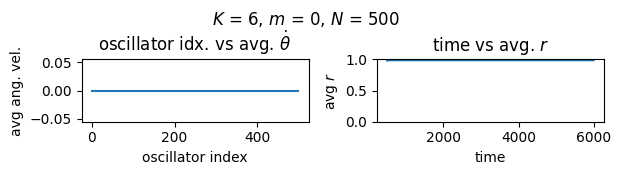

In [9]:
Draw_avg_vel_r(t_sum=t_sum,avg_r=avg_r,KmN=(K,m,N),avg_dtheta=avg_dtheta,Cidx=[])

In [47]:

def to_cluster(idx,peaks_new,arg):
    C = idx,idx+1
    arg_C = peaks_new[C[0]],peaks_new[C[1]]
    cluster = arg[arg_C[0]:arg_C[1]]
    return cluster
def to_cluster_barg(idx,peaks_new):
    C = idx,idx+1
    arg_C = peaks_new[C[0]],peaks_new[C[1]]
    cluster = np.arange(arg_C[0],arg_C[1])
    return cluster
def to_cstability(x,diff_dtheta):
    try:
        return np.mean(diff_dtheta[x[1:]])
    except IndexError:
        return np.nan
def to_mean_avg_d_o(x,avg_dtheta,index):
    try:
        return np.mean(avg_dtheta[index][x])
    except IndexError:
        return np.nan
iter_time = 200*5
num = 0
for index in range(-iter_time,0):
    arg = np.argsort(avg_dtheta[index])
    SD = avg_dtheta[index][arg]
    diff_dtheta = np.diff([SD[0],*SD,SD[-1]])
    peaks, P  = find_peaks(diff_dtheta, height=0.01)
    
    # peaks = peaks[np.where((peaks<N)&(peaks>1))]

    try:
        peaks_new = np.array([peaks[0],*peaks])
    except IndexError:
        peaks_new = np.array([0,N])

    psize = np.diff(peaks_new)
    arg_psize = np.argsort(psize)[::-1]
    sort_psize = np.sort(psize)[::-1]
    clusters = np.array([to_cluster_barg(arg,peaks_new) for arg in arg_psize],dtype=object)[:10]
    if len(clusters) == 1:
        clusters = np.array([np.arange(peaks_new[0],N)])
    c_stability = np.array(list(map(to_cstability,clusters,[diff_dtheta]*len(clusters))))
    mean_omega = np.array(list(map(to_mean_avg_d_o,clusters,[avg_dtheta]*len(clusters),[index]*len(clusters))))
    if num==0:
        psize_array = sort_psize[:10]
        cluster_array = clusters
        c_stability_array = c_stability
        mean_omega_array = mean_omega
        arg_array = arg

        num+=1
    else:
        cluster_array = np.c_[cluster_array,clusters]
        psize_array = np.c_[psize_array,sort_psize[:10]]
        c_stability_array = np.c_[c_stability_array,c_stability]
        mean_omega_array = np.c_[mean_omega_array,mean_omega]
        arg_array = np.c_[arg_array,arg]
        

Is_group = np.where((np.std(psize_array,axis=1) == 0)&(psize_array[:,-1]>5))
# Is_group = np.where((np.std(mean_omega_array,axis=1) < 1e-3)&(psize_array[:,-1]>5)) # 그룹을 개수로 판별하기 때문에 개수가 같아 그룹이 이동하면 그룹이 아닌걸로 판별해야 한다.
mean_group_s = np.mean(c_stability_array,axis=1)
Is_group_s = np.where((mean_group_s<1e-4)&(psize_array[:,-1]>5))
print(Is_group,mean_group_s,Is_group_s)

(array([0]),) [2.06942300e-06 6.19840240e-03 5.99072156e-03 6.89076572e-03
 9.95145936e-03 1.07470283e-02 1.08144614e-02 1.08868024e-02
 9.06286991e-03 3.65855253e-03] (array([0]),)


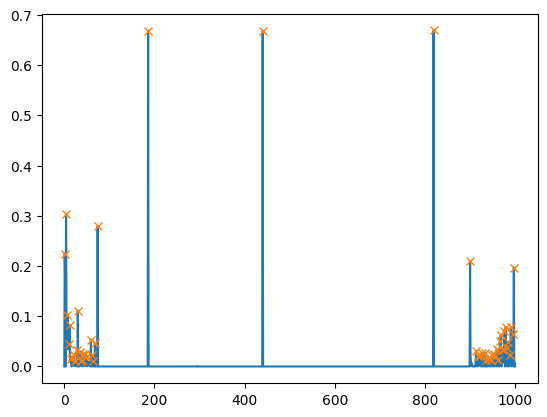

In [275]:
plt.plot(diff_dtheta)
plt.plot(peaks,diff_dtheta[peaks],'x')

In [259]:
c_stability = np.array([np.mean(diff_dtheta[to_cluster_barg(arg_psize[i],peaks_new)[1:]]) for i in range(len(arg_psize))])[:10]

In [260]:
to_cluster_bargx = lambda x: to_cluster_barg(x,peaks_new=peaks_new)

712 512 229 167 24 18 14 12 12 11 11 10 9 9 8 8 7 7 7 6 6 6 6 6 6 6 5 5 5 5 5 5 5 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 0
2.749095176966214e-06 4.487679268969803e-06 1.9360981686444067e-06 4.874008842158022e-06 0.0030753922618755964 0.004028485599259142 0.002129949842884803 0.003027210590620368 0.002506037489014174 0.0017228834529366744 0.002178174779457609 0.0004438318063530764 0.004181714228643968 0.001554661961669257 0.0025245780897143544 0.0023326131270628675 0.0046543207209974735 0.0001259393650990074 0.004731746057065907 0.003333159758599935 0.0026214692914462655 0.007328834511346649 0.0042186699562356544 0.005479335937626883 0.0021990487106889668 0.009189917859459574 0.00572711335399656 0.01154264619973977 0.0022518871083455627 0.0042108556354956694 0.004198591793990625 0.0021980238668518615 0.0029021514455235264 0.003116988594330905 0.0041172246384797995 0.012188007341810358 0.0046335349362848595 0.005291067976293122 0.005699737829877

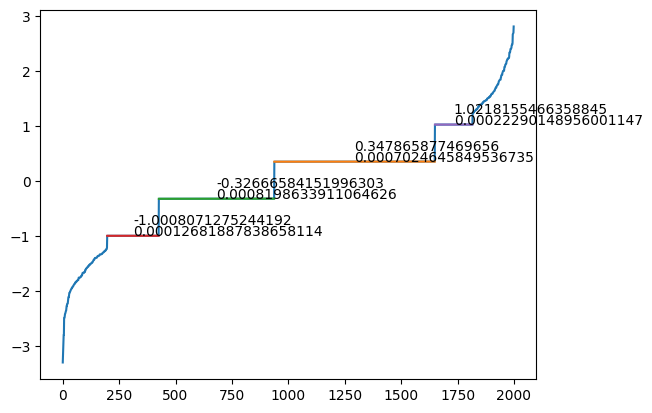

In [261]:
clusters = [to_cluster_barg(arg_psize[i],peaks_new) for i in range(len(arg_psize))]
print(*list(map(len,clusters)))
print(*list(map(to_cstability,clusters,[diff_dtheta]*len(clusters))))
print(*list(map(to_mean_avg_d_o,clusters,[avg_dtheta]*len(clusters),[index]*len(clusters))))

plt.plot(avg_dtheta[-1][arg])
# for i in range(8):
for i in Is_group[0]:
    # i = 0
    x = to_cluster_bargx(arg_psize[i])[:]
    y = avg_dtheta[-1][arg][x]
    plt.plot(x,y)
    plt.text(np.mean(x),np.mean(y),f'{np.std(y)}')
    plt.text(np.mean(x),np.mean(y)+0.2,f'{np.mean(y)}')

In [201]:
mean_omega

array([ 0.12735082, -0.71960801,  0.96951884, -1.58948587,  1.27795946,
       -1.38810102,  1.34331736, -1.71943252,  2.34557299, -1.15624739])

In [202]:
Is_group

(array([0, 1, 2, 4]),)

In [203]:
abs(mean_omega_array[Is_group]-mean_omega_array[0]).T.shape

(1000, 4)

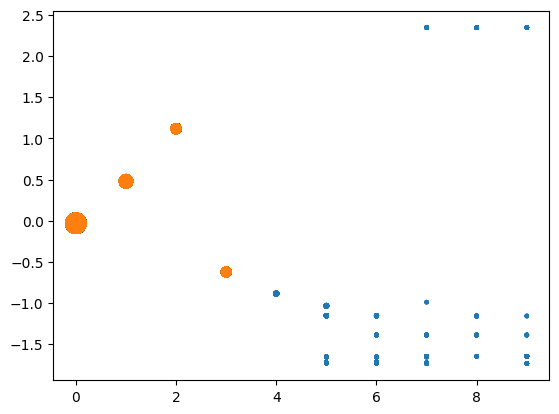

In [247]:
plt.scatter(np.array([np.arange(len(mean_omega_array.T[0])) for i in range(1000)]),(mean_omega_array).T,s=psize_array.T);
plt.scatter(np.array([np.arange(len(mean_omega_array[Is_group].T[0])) for i in range(1000)]),(mean_omega_array[Is_group]).T,s=psize_array[Is_group].T);

In [42]:
mean_omega

array([ 0.03495559, -1.49706609,  2.2668969 ,  1.37804924, -1.88075726,
       -1.03196914, -1.77905668, -1.27398378,  1.65887824, -2.03190253])

In [157]:

print(Is_group)
L_cluster = {}
R_cluster = {}
M_cluster = []

num = 0
L_cluster_sort = {}
R_cluster_sort = {}
M_cluster_sort = []
if len(Is_group[0]) !=0:
    for index in range(-iter_time,0):
        arg = np.argsort(avg_dtheta[index])
        SD = avg_dtheta[index][arg]
        diff_dtheta = np.diff([SD[0],*SD])
        peaks, P  = find_peaks(diff_dtheta, height=0.01)
        peaks = peaks[np.where((peaks<N)&(peaks>1))]

        try:
            peaks_new = np.array([peaks[0],*peaks])
        except IndexError:
            peaks_new = np.array([0,N])
        psize = np.diff(peaks_new)
        arg_psize = np.argsort(psize)[::-1]

        if -iter_time == index:
            sort_psize = np.sort(psize)[::-1]
            
            IS_main = []
            for i in range(10):
                C = arg_psize[i],arg_psize[i]+1
                arg_C = peaks_new[C[0]],peaks_new[C[1]]
                cluster = arg[arg_C[0]:arg_C[1]]
                if (N//2 in cluster)&(num==0):
                    main_i = i
                    num+=1
                IS_main.append(np.mean(abs(cluster -N//2)))
            main_i = np.argmin(IS_main)
            main_10 = arg_psize[:10][Is_group]
            
            M_cluster_idx = main_10[main_i]
            L_cluster_idx = main_10[main_10<main_10[main_i]]
            L_cluster_g = Is_group[0][main_10<main_10[main_i]]
            R_cluster_idx = main_10[main_10>main_10[main_i]]
            R_cluster_g = Is_group[0][main_10>main_10[main_i]]
            for i,idx in enumerate(L_cluster_idx):
                L_c = to_cluster(idx,peaks_new=peaks_new,arg=arg)
                L_cluster[i] = L_c
                print('L',i,idx,len(L_c),psize[idx])
            for i,idx in enumerate(R_cluster_idx):
                R_c = to_cluster(idx,peaks_new=peaks_new,arg=arg)
                R_cluster[i] = R_c
                print('R',i,idx,len(R_c),psize[idx])
            M_cluster = to_cluster(M_cluster_idx,peaks_new=peaks_new,arg=arg)
            print("M",len(M_cluster))
            # break
        else:
            main_10 = arg_psize[:10][Is_group]
            M_cluster_idx = main_10[main_i]
            L_cluster_idx = arg_psize[:10][L_cluster_g]
            R_cluster_idx = arg_psize[:10][R_cluster_g]
            M_cluster = np.c_[M_cluster,to_cluster(M_cluster_idx,peaks_new=peaks_new,arg=arg)]

            for i,Lidx in enumerate(L_cluster_idx):
                try:
                    L_cluster[i] = np.c_[L_cluster[i],to_cluster(Lidx,peaks_new=peaks_new,arg=arg)]
                except ValueError:
                    print(L_cluster[i].shape,len(to_cluster(Lidx,peaks_new=peaks_new,arg=arg)))

            for i,Ridx in enumerate(R_cluster_idx):
                try:
                    R_cluster[i] = np.c_[R_cluster[i],to_cluster(Ridx,peaks_new=peaks_new,arg=arg)]
                except ValueError:
                    print(R_cluster[i].shape,len(to_cluster(Ridx,peaks_new=peaks_new,arg=arg)))
                    # break

(array([0, 1, 2, 4]),)
L 0 6 47 47
L 1 2 8 8
R 0 8 48 48
M 351


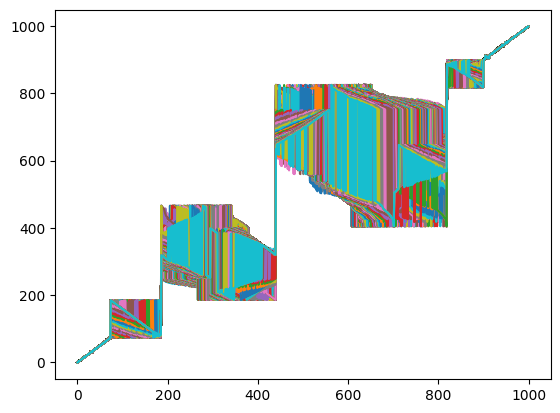

In [239]:
plt.plot(arg_array);

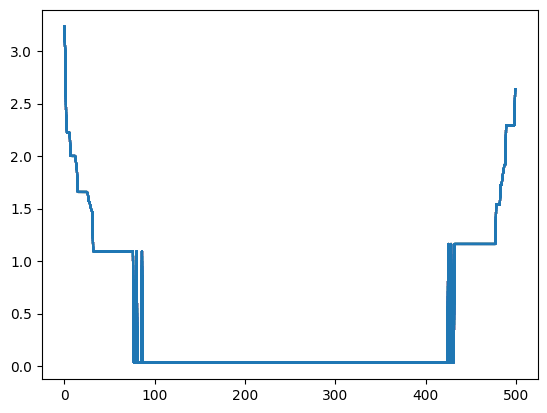

In [127]:
plt.plot(abs(avg_dtheta[-100:].T),alpha=0.1,zorder=0,color ='tab:blue');

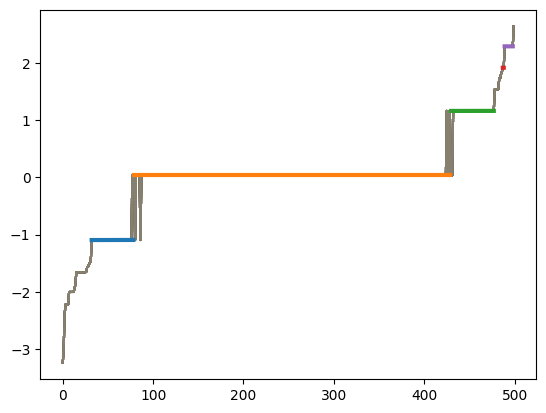

In [145]:
MAIN = np.argsort(mean_omega_array.T[-1][Is_group])
CCC = cluster_array.T[-1][Is_group][MAIN]
plt.plot(avg_dtheta[-100:].T,alpha=0.1,zorder=1)

for i in CCC:
    plt.plot(i,avg_dtheta[-1][arg][i],lw=3,)


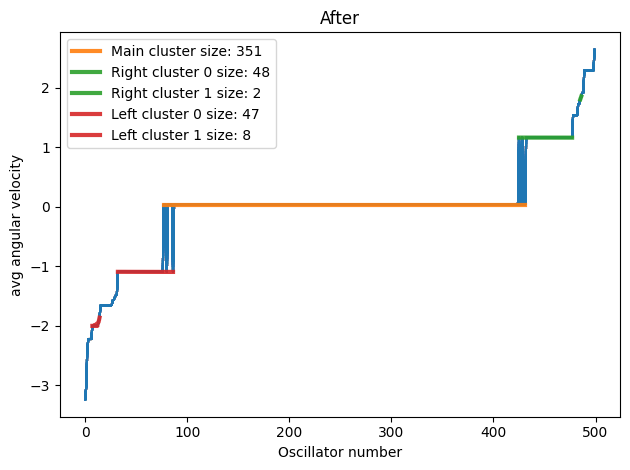

In [128]:
main_10 = arg_psize[:10]
plt.plot(avg_dtheta[-100:].T,alpha=0.1,zorder=0,color ='tab:blue')
cluster = M_cluster[:,-1]
plt.plot(cluster,avg_dtheta[-1][cluster],color = 'tab:orange',lw=3,alpha=0.9,label = f'Main cluster size: {len(cluster)}',zorder=1)
for i,idx in enumerate(R_cluster.keys()):
    cluster = R_cluster[i][:,-1]
    plt.plot(cluster,avg_dtheta[-1][cluster],color = 'tab:green',lw=3,alpha=0.9,label = f'Right cluster {i} size: {len(cluster)}',zorder=1)
for i,idx in enumerate(L_cluster.keys()):
    cluster = L_cluster[i][:,-1]
    plt.plot(cluster,avg_dtheta[-1][cluster],color = 'tab:red',lw=3,alpha=0.9,label = f'Left cluster {i} size: {len(cluster)}',zorder=1)




plt.title('After')
plt.xlabel('Oscillator number')
plt.ylabel('avg angular velocity')
plt.legend()
plt.tight_layout()